# Needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import time
from scipy import stats
import seaborn as sbn
import pandas as pd
import h5py
import os

In [4]:
from keras.layers import Lambda, Input, Dense, Dropout, AveragePooling2D, Flatten, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.losses import mse, binary_crossentropy, mean_absolute_percentage_error
from keras.utils import plot_model,to_categorical
from keras import backend as K
from keras import callbacks
#from sklearn.preprocessing import LabelEncoder,OneHotEncoder,image,label_binarize
from keras.utils import plot_model
from keras.optimizers import SGD, Adam
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import roc_curve,roc_auc_score,mean_squared_error
#from keras.applications.resnet50 import ResNet50
import tensorflow as tf
import keras.losses as kLoss
from keras import optimizers

2025-02-28 13:00:23.671018: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 13:00:23.743534: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 13:00:23.743979: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-28 13:00:24.508794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
print('numpy version:', np.__version__)
print('matplotlib version:', mpl.__version__)
print('tensorflow version:', tf.__version__)

color_rate = "#d55e00"
color_drate = 'darkblue' #"#0072b2"
color_s1s2 = 'limegreen' #"#009e73"
color_comb = 'limegreen'

# Check if gpu is available
if tf.test.is_gpu_available():
    device = 'gpu'
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

numpy version: 1.24.4
matplotlib version: 3.4.3
tensorflow version: 2.13.1
Using CPU


# Reading data

In [8]:
images = np.load('../data/TNGgalaxies_28_02/images.npy')
labels = np.load('../data/TNGgalaxies_28_02/labels.npy')

In [9]:
print(f'There are {len(np.where(np.isnan(images) == True)[0])} nans in images')
print(f'There are {len(np.where(np.isnan(labels) == True)[0])} nans in labels')

There are 3086 nans in images
There are 0 nans in labels


In [10]:
images = np.nan_to_num(images, nan=0)

In [11]:
images = np.moveaxis(images, 1, -1)

In [13]:
images = images[:100,:,:,:]
labels = labels[:100,:]

In [14]:
nobs, npix, _, nch = images.shape

In [15]:
np.random.seed(28890)
random_ind = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_size = int(0.7 * nobs)
val_size = int(0.2 * nobs)
test_size = nobs - train_size - val_size

train_ind = random_ind[:train_size]
val_ind = random_ind[train_size:(val_size + train_size)]
test_ind = random_ind[-test_size:]

In [16]:
x_trainset = images[train_ind,:,:,:]
x_valset = images[val_ind,:,:,:]
x_testset = images[test_ind,:,:,:]

y_trainset = np.log10(labels[train_ind,0,:])
y_valset = np.log10(labels[val_ind,0,:])
y_testset = np.log10(labels[test_ind,0,:])

In [17]:
min_x = np.min(x_trainset)
max_x = np.max(x_trainset)

min_y = np.min(y_trainset, axis = 0)
max_y = np.max(y_trainset, axis = 0)

In [18]:
x_trainset = (x_trainset - min_x) / (max_x - min_x)
x_valset = (x_valset - min_x) / (max_x - min_x)
x_testset = (x_testset - min_x) / (max_x - min_x)

y_trainset = (y_trainset - min_y) / (max_y - min_y)
y_valset = (y_valset - min_y) / (max_y - min_y)
y_testset = (y_testset - min_y) / (max_y - min_y)

In [19]:
min_x

-73866.63006661664

# Playing with CNNs

In [20]:
# network parameters
input_shape = (npix, npix, nch) # Input shape (#rows, #cols, #channels)
actFunction = 'relu'

# Hidden layers dimensions
intermediate_dim1 = 500
intermediate_dim2 = 400
intermediate_dim3 = 300
intermediate_dim4 = 200
output_dim        = y_trainset.shape[1]

## First let's check that it overfit 1 batch

* It seems to converge to MSE = 0.0451 (without batch normalization nor dropout)

In [120]:
# build model
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5), strides = 1 , padding = 'same', input_shape = input_shape))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 15, kernel_size = (5,5), strides = 1 , padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 30, kernel_size = (5,5), strides = 1 , padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.2)) 
model.add(Flatten())

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim1, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim2, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim3, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim4, activation = 'linear'))

model.add(Dense(output_dim, name = 'output'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 5)       1005      
                                                                 
 batch_normalization_7 (Bat  (None, 128, 128, 5)       20        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 128, 128, 5)       0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 64, 64, 5)         0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 15)        1890      
                                                                 
 batch_normalization_8 (Bat  (None, 64, 64, 15)       

In [122]:
# instantiate model
optimizer = optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(optimizer = optimizer, loss = 'mse', metrics=['mae','mse'])

In [103]:
batch_size = 32
epochs     = 250
history = model.fit(x_trainset[:batch_size], y_trainset[:batch_size],
                   epochs = epochs,
                   validation_data = (x_trainset[:batch_size], y_trainset[:batch_size]))

Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 0.3322 - mae: 0.5282 - mse: 0.3322 - val_loss: 0.3210 - val_mae: 0.5184 - val_mse: 0.3210
Epoch 2/250
1/1 [==============================] - 0s 265ms/step - loss: 0.3210 - mae: 0.5184 - mse: 0.3210 - val_loss: 0.3104 - val_mae: 0.5089 - val_mse: 0.3104
Epoch 3/250
1/1 [==============================] - 0s 275ms/step - loss: 0.3104 - mae: 0.5089 - mse: 0.3104 - val_loss: 0.3009 - val_mae: 0.5002 - val_mse: 0.3009
Epoch 4/250
1/1 [==============================] - 0s 345ms/step - loss: 0.3009 - mae: 0.5002 - mse: 0.3009 - val_loss: 0.2919 - val_mae: 0.4918 - val_mse: 0.2919
Epoch 5/250
1/1 [==============================] - 0s 314ms/step - loss: 0.2919 - mae: 0.4918 - mse: 0.2919 - val_loss: 0.2837 - val_mae: 0.4839 - val_mse: 0.2837
Epoch 6/250
1/1 [==============================] - 0s 291ms/step - loss: 0.2837 - mae: 0.4839 - mse: 0.2837 - val_loss: 0.2761 - val_mae: 0.4765 - val_mse: 0.2761
Epoch 7/250
1/1 [========

(0.0, 1.0)

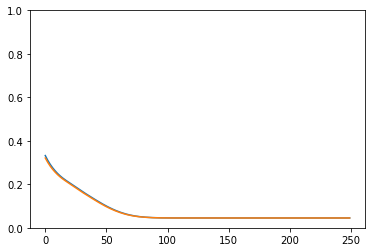

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)

In [105]:
y_predicted = model.predict(x_trainset[:batch_size]) * (max_y - min_y) + min_y

1/1 [==============================] - 0s 121ms/step


In [109]:
y_trainset.shape

(70, 20)

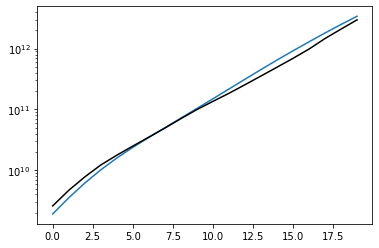

In [112]:
i = 22
plt.plot(10**(y_predicted[i,:]))
plt.plot(10**(y_trainset[i,:] * (max_y - min_y) + min_y), c = 'black')
plt.yscale('log')

## Now let's play the real game

* Seems to converge to MSE = 0.054 (without batch normalization nor dropout)

In [129]:
# build model
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5), strides = 1 , padding = 'same', input_shape = input_shape))
model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 15, kernel_size = (5,5), strides = 1 , padding = 'same'))
model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 30, kernel_size = (5,5), strides = 1 , padding = 'same'))
model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2)) 
model.add(Flatten())

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim1, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim2, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim3, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim4, activation = 'linear'))

model.add(Dense(output_dim, name = 'output'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 5)       1005      
                                                                 
 batch_normalization_21 (Ba  (None, 128, 128, 5)       20        
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 128, 128, 5)       0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 64, 64, 5)         0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 15)        1890      
                                                                 
 batch_normalization_22 (Ba  (None, 64, 64, 15)       

In [130]:
# instantiate model
optimizer = optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(optimizer = optimizer, loss = 'mse', metrics=['mae','mse'])

In [135]:
batch_size = 32
epochs     = 250
history = model.fit(x_trainset, y_trainset,
                   epochs = epochs,
                   callbacks = [mc],
                   validation_data = (x_valset, y_valset))

Epoch 1/250
3/3 [==============================] - ETA: 0s - loss: 0.0530 - mae: 0.1808 - mse: 0.0530
Epoch 1: val_loss did not improve from 0.05286
3/3 [==============================] - 1s 250ms/step - loss: 0.0530 - mae: 0.1808 - mse: 0.0530 - val_loss: 0.0669 - val_mae: 0.2041 - val_mse: 0.0669
Epoch 2/250
3/3 [==============================] - ETA: 0s - loss: 0.0530 - mae: 0.1823 - mse: 0.0530
Epoch 2: val_loss did not improve from 0.05286
3/3 [==============================] - 1s 236ms/step - loss: 0.0530 - mae: 0.1823 - mse: 0.0530 - val_loss: 0.0684 - val_mae: 0.2066 - val_mse: 0.0684
Epoch 3/250
3/3 [==============================] - ETA: 0s - loss: 0.0493 - mae: 0.1753 - mse: 0.0493
Epoch 3: val_loss did not improve from 0.05286
3/3 [==============================] - 1s 239ms/step - loss: 0.0493 - mae: 0.1753 - mse: 0.0493 - val_loss: 0.0696 - val_mae: 0.2086 - val_mse: 0.0696
Epoch 4/250
3/3 [==============================] - ETA: 0s - loss: 0.0516 - mae: 0.1799 - mse: 0.051

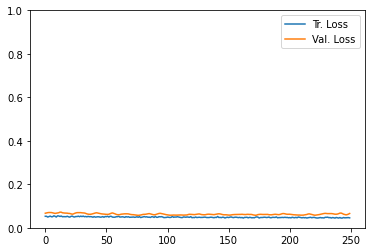

In [136]:
plt.plot(history.history['loss'], label = 'Tr. Loss')
plt.plot(history.history['val_loss'], label = 'Val. Loss')
plt.ylim(0,1)
plt.legend()

In [137]:
y_predicted = model.predict(x_testset) * (max_y - min_y) + min_y

1/1 [==============================] - 0s 29ms/step


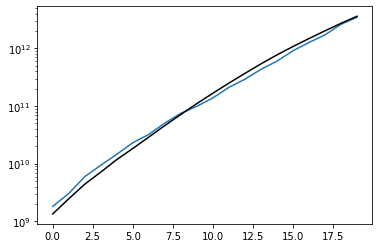

In [138]:
i = 4
plt.plot(10**(y_predicted[i,:]))
plt.plot(10**(y_testset[i,:] * (max_y - min_y) + min_y), c = 'black')
plt.yscale('log')

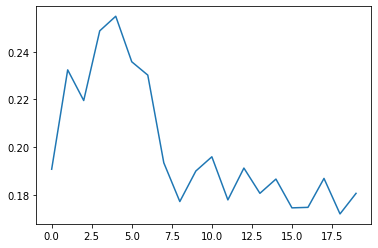

In [143]:
plt.plot(np.sqrt(np.sum((y_testset * (max_y - min_y) + min_y - y_predicted)**2, axis = 0) / len(y_testset)))